$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 6: YOLO - Objects Detection
<a id=part6></a>

In this part we will use an object detection architecture called YOLO (You only look once) to detect objects in images. We'll use an already trained model weights (v5) found here: https://github.com/ultralytics/yolov5

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the YOLO model
model = torch.hub.load("ultralytics/yolov5", "yolov5s")
model.to(device)
# Images
img1 = 'imgs/DolphinsInTheSky.jpg'  
img2 = 'imgs/cat-shiba-inu-2.jpg' 

Using cache found in /home/ilay.kamai/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-15 Python-3.8.12 torch-1.10.1 CUDA:0 (NVIDIA GeForce RTX 2080, 7982MiB)



requirements: /home/ilay.kamai/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


## Inference with YOLO
<a id=part6_1></a>

You are provided with 2 images (img1 and img2).
**TODO**:
1. Detect objects using the YOLOv5 model for these 2 images.
2. Print the inference output with bounding boxes.
3. Calculate the number of pixels within a bounding box and the number in the background.
   
   **Hint**: Given you stored the model output in a varibale named 'results', you may find 'results.pandas().xyxy' helpful 
4. Look at the inference results and answer the question below.


imgs/DolphinsInTheSky.jpg
total number of pixels in all bounding boxes:  13173  0.26 of image pixels
total number of pixels in background:  37152  0.74 of image pixels


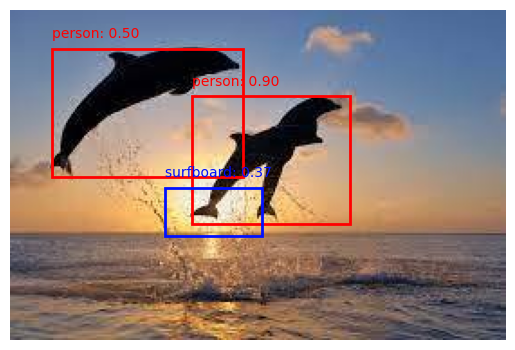

imgs/cat-shiba-inu-2.jpg
total number of pixels in all bounding boxes:  406433  0.72 of image pixels
total number of pixels in background:  156067  0.28 of image pixels


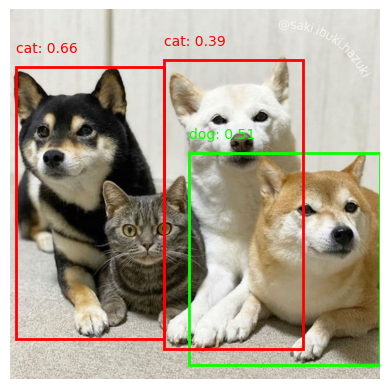

In [2]:
#Insert the inference code here.
import math
import cv2
import numpy as np
# from torch.nn.functional import pad
from matplotlib import pyplot as plt
%matplotlib inline
def plot_boxes(img, df):
    """
    Plot bounding boxes on image
    """
    colors = plt.cm.hsv(np.linspace(0, 1, len(df)+1).tolist())
    classes = df['class']
    plt.imshow(img)
    plt.axis('off')
    tot_box_size = 0
    ref_img = torch.zeros((img.shape[0], img.shape[1]))
    for i in range(len(df)):
        row = df.iloc[i]
        x1,y1,x2,y2 = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        conf = row['confidence']
        name = row['name']
        cls = row['class']
        ref_img[int(y1):int(y2), int(x1):int(x2)] =1
        tot_box_size += int((x2-x1)*(y2-y1))
#         x1, y1, x2, y2 = df[['xmin', 'ymin', 'xmax', 'ymax']].values.tolist()
#         conf = confs[i]
#         cls = classes[i]
        color = colors[np.where(classes==cls)[0][0]]
        label = f"{name}: {conf:.2f}"
        y_offset = int(img.shape[0]*0.07)
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, linewidth=2, edgecolor=color))
        plt.gca().text(x1, y1-y_offset, label,color=color, fontsize=10, ha='left', va='top')
    tot_pixels = img.shape[0]*img.shape[1]
    box_pixels = len(torch.where(ref_img)[0])
    background_pixels = len(torch.where(ref_img==0)[0])
    print("total number of pixels in all bounding boxes: ", box_pixels, " {:.2f} of image pixels".format(box_pixels/tot_pixels))
    print("total number of pixels in background: ", background_pixels, " {:.2f} of image pixels".format(background_pixels/tot_pixels))
    
    plt.show()
img1_arr = cv2.imread(img1)[:,:,::-1] 
img2_arr = cv2.imread(img2)[:,:,::-1]
# plt.imshow(img2_arr)
# plt.show()
for im in [img1, img2]:
    print(im)
    with torch.no_grad():
        results = model(im)
        df = results.pandas().xyxy[0]
        # print(df)
        im_arr = cv2.imread(im)[:,:,::-1]
        plot_boxes(im_arr, df)


### Question 1

Analyze the inference results of the 2 images. 
1. How well did the model detect the objects in the pictures?
2. What can possibly be the reason for the model failures? suggest methods to resolve that issue.

In [3]:
from cs236781.answers import display_answer
import hw2.answers

In [4]:
display_answer(hw2.answers.part6_q1)



**Your answer:**


in generall, the model did not performed well on those pictures. in the first image there are three dolphins.
the model located on of the bounding box correctly, but the other two bounding boxes are not accurate. the labels is also
not accurate -  the model interperted the scene
as persons on a surfboard, and therefore labeled the dolphins as "person" or "surfboard". this implies a bias in the dataset
the model was trained on - the model was trained on a dataset with many images of persons on surfboards, and therefore when it
see an object above the water it interpert it as a person on a surfboard.
in the second image there are three dogs and one cat close to each other. here, the model 
located 2 bounding boxes over cat and dog together and labeled them as a cat.
possible reasons for the poor performance are: small number of classes - even when the model located the bounding box correctly,
it labeled the object not correctly. this is because the model was trained on a dataset with limited number of
classes (the basic model was trained on COCO dataset which has 80 classes).
another reason is occulusion - in the second image the cat is occluded by the dog, and the model failed to locate it. 
<br>
to resolve those issues we can: 
<br>
1. train the model on a dataset with more classes (e.g imagenet) and fine tune it on our dataset.
<br>
2. train the model on a dataset with more variability per class - many instances of the same class in different poses.
<br>
3. train the model with different size of bounding boxes to allow the model better seperate between close objects.
<br>
4. change the number of bounding boxes per grid cell to allow the model to locate more objects in the same grid cell. 




## Creative Detection Failures

<a id=part6_2></a>

Object detection pitfalls could be, for example: **occlusion** - when the objects are partially occlude, and thus missing important features, **model bias** - when a model learn some bias about an object, it could recognize it as something else in a different setup, and many others like **Deformation**, **Illumination conditions**, **Cluttered** or **textured background and blurring** due to moving objects.

**TODO**: Take pictures and that demonstrates 3 of the above object detection pitfalls, run inference and analyze the results.

In [26]:
os.path.splitext("img/YOLO/bear2.jpg")[1]

'.jpg'

imgs/YOLO/ducks.png
total number of pixels in all bounding boxes:  1830  0.01 of image pixels
total number of pixels in background:  237486  0.99 of image pixels


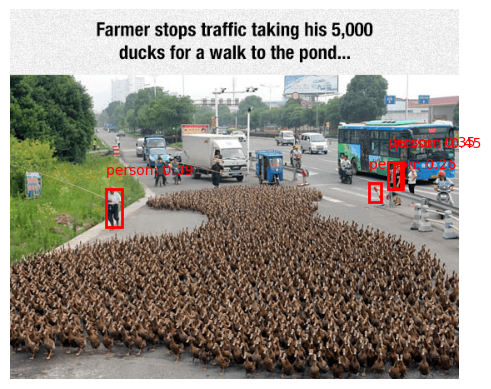

imgs/YOLO/cow_and_cat.jpeg
total number of pixels in all bounding boxes:  372931  0.54 of image pixels
total number of pixels in background:  316009  0.46 of image pixels


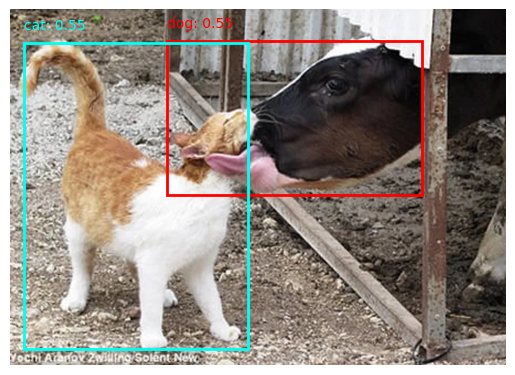

imgs/YOLO/bear2.jpg
total number of pixels in all bounding boxes:  523076  0.48 of image pixels
total number of pixels in background:  556924  0.52 of image pixels


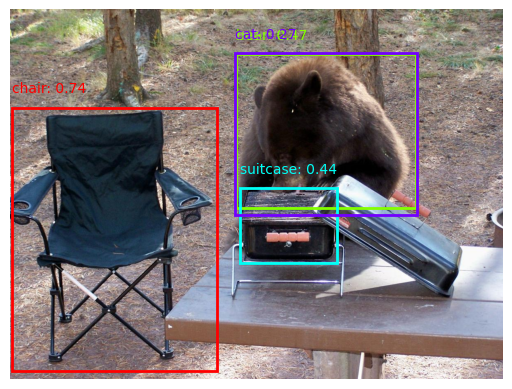

imgs/YOLO/shadow.jpg
total number of pixels in all bounding boxes:  3351420  0.19 of image pixels
total number of pixels in background:  14564484  0.81 of image pixels


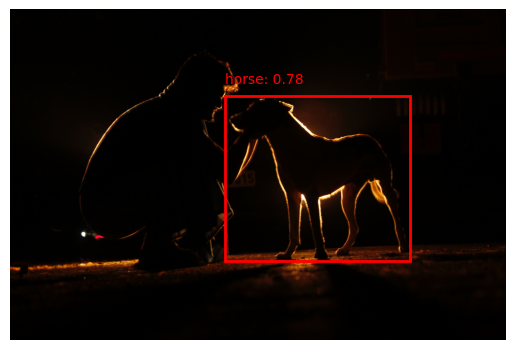

imgs/YOLO/donkey.jpg
total number of pixels in all bounding boxes:  447736  0.36 of image pixels
total number of pixels in background:  795064  0.64 of image pixels


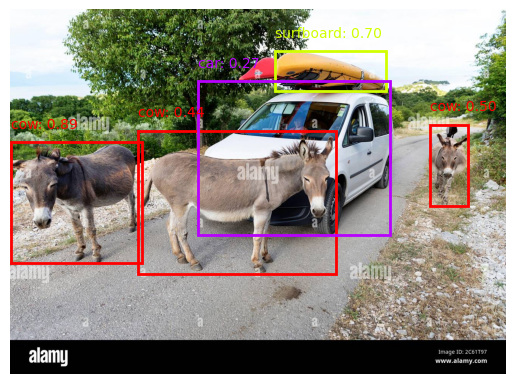

In [34]:
import os
imgs = [os.path.join("imgs/YOLO", f) for f in os.listdir("imgs/YOLO") if os.path.splitext(f)[1] in [".jpg", ".jpeg", ".png"]]
for im in imgs:
    print(im)
    with torch.no_grad():
        results = model(im)
        df = results.pandas().xyxy[0]
        im_arr = cv2.imread(im)[:,:,::-1]
        plot_boxes(im_arr, df)




### Question 3

Analyize the results of the inference. 
1. How well did the model detect the objects in the pictures? explain.


imgs/YOLO/ducks.png
total number of pixels in all bounding boxes:  13192  0.06 of image pixels
total number of pixels in background:  226124  0.94 of image pixels


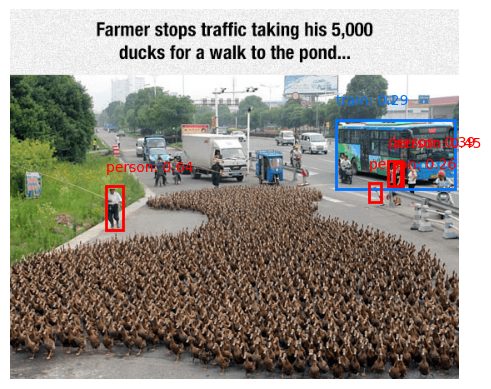

imgs/YOLO/cow_and_cat.jpeg
total number of pixels in all bounding boxes:  599211  0.87 of image pixels
total number of pixels in background:  89729  0.13 of image pixels


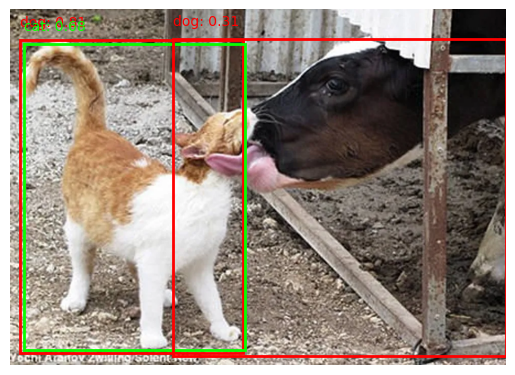

imgs/YOLO/bear2.jpg
total number of pixels in all bounding boxes:  744540  0.69 of image pixels
total number of pixels in background:  335460  0.31 of image pixels


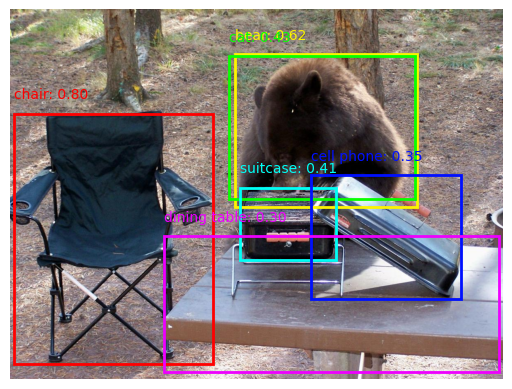

imgs/YOLO/shadow.jpg
total number of pixels in all bounding boxes:  7049979  0.39 of image pixels
total number of pixels in background:  10865925  0.61 of image pixels


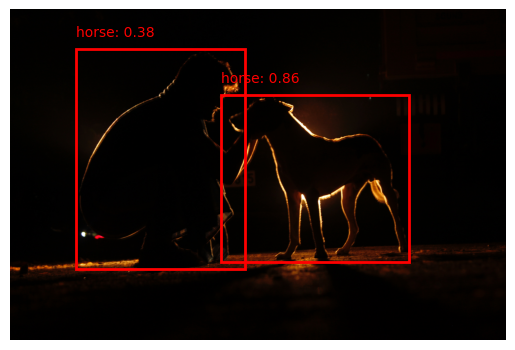

imgs/YOLO/donkey.jpg
total number of pixels in all bounding boxes:  455483  0.37 of image pixels
total number of pixels in background:  787317  0.63 of image pixels


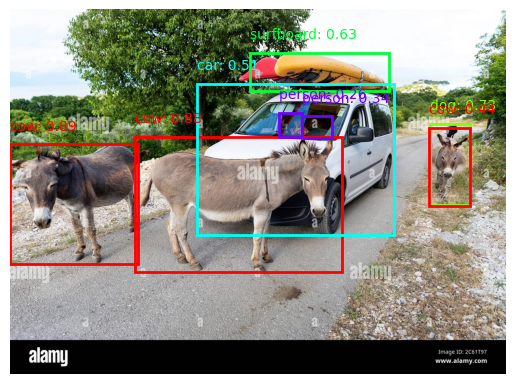

In [47]:
from torchvision.transforms import functional as F
from PIL import Image
# image = Image.open('imgs/YOLO/shadow.jpg')
# image.show()

class AugmentYOLO(torch.nn.Module):
    def __init__(self, yolo):
        super().__init__()
        self.yolo = yolo
    def forward(self, x, **kw):
        return self.yolo(x, **kw)
    def forward_augment(self, x):
        img_size = x.shape[-2:]  # height, width
        s = [1, 0.83, 0.67, 0.4]  # scales
        f = [None, 3, None, 2, None]  # flips (2-ud, 3-lr)
        y = []  # outputs
        for si, fi in zip(s, f):
            xi = scale_img(x.flip(fi) if fi else x, si, gs=int(self.stride.max()))
            xi = F.adjust_brightness(image, 1.5)
            yi = self.forward_once(xi)[0]  # forward
            # cv2.imwrite(f'img_{si}.jpg', 255 * xi[0].cpu().numpy().transpose((1, 2, 0))[:, :, ::-1])  # save
            yi = self._descale_pred(yi, fi, si, img_size)
            y.append(yi)
        return torch.cat(y, 1), None  # augmented inference, train
a_yolo = AugmentYOLO(model)

for im in imgs:
    print(im)
    with torch.no_grad():
        results = a_yolo(im, augment=True)
        df = results.pandas().xyxy[0]
        im_arr = cv2.imread(im)[:,:,::-1]
        plot_boxes(im_arr, df)
    

In [6]:
display_answer(hw2.answers.part6_q3)



**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$



## Bonus 
<a id=part6_3></a>

Try improving the model performance over poorly recognized images by changing them. 
Describe the manipulations you did to the pictures.

In [7]:
#insert bonus code here

In [8]:
display_answer(hw2.answers.part6_bonus)



**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$

